In [1]:
import requests
import pandas as pd
import numpy as np 
from tqdm import tqdm


In [2]:
def get_names_geo_data_from_sncf_api(endpoint_suffix,**kwargs):
    base_url = "https://ressources.data.sncf.com"
    # Endpoint for the desired dataset
    endpoint = f"/api/explore/v2.1/catalog/datasets/{endpoint_suffix}/records"
    # Parameters for the API request
    params = {
        
        "limit": 100,  # in this API maximum limit is 100
        "offset": 0,  # we start from 0 to 100, then FROM 100 to 200 etc etc, but limit is fixed at 100, it is moving
        
    }
    params.update(kwargs)
    # Construct the full URL
    url = f"{base_url}{endpoint}"
    response = requests.get(url, params=params)
    wb = response.json()
    resulting_dictionnary = wb["results"].copy()
    while wb["results"] != []:
        params["offset"] = params["offset"] + 100
        response = requests.get(url, params=params)
        if response.status_code == 200:
            wb = response.json()
            for element in wb["results"]:
                resulting_dictionnary.append(element)
    # verify nb of observations
    print(f"nb of stations downloaded: {len(resulting_dictionnary)}")
    df = pd.json_normalize(resulting_dictionnary)
    return df
def get_absent_lat_lon_from_gouv_api(df):
    empties = df[df["lon"].isna()].copy()
    base_url = "https://api-adresse.data.gouv.fr/search/"
    # Paramètres de la requête
    params = {"q": "", "limit": 1}
    i = 0
    for idx, row in empties.iterrows():
        params["q"] = "gare de "+row["nom_gare"]
        response = requests.get(base_url, params=params)
        if response.status_code == 200:
            data = response.json()
            coordinates = data["features"][0]["geometry"]["coordinates"]
            i = i + 1
        else:
            coordinates = [None, None]
        df.loc[idx, "lon"] = coordinates[0]
        df.loc[idx, "lat"] = coordinates[1]
    print(i, "absent addresses filled successfully")
    return df

In [3]:
df = get_names_geo_data_from_sncf_api(
    endpoint_suffix="gares-de-voyageurs",
    select="""nom as nom_gare,
                           position_geographique,
                           codeinsee,
                           codes_uic as uic""",
)
df = df.drop("position_geographique", axis=1)

df.rename(
    columns={
        "position_geographique.lon": "lon",
        "position_geographique.lat": "lat",
    },
    inplace=True,
)


nb of stations downloaded: 2881


In [4]:
frequentation = get_names_geo_data_from_sncf_api(
    endpoint_suffix="frequentation-gares",
    select="""total_voyageurs_2023,
                           code_postal,
                           nom_gare,
                           code_uic_complet as uic """,
)

nb of stations downloaded: 3010


In [5]:
property = get_names_geo_data_from_sncf_api(
    endpoint_suffix="proprete-en-gare",
    select="""nom_gare,
                           uic ,
                           avg(taux_de_conformite) as taux_de_conformite """,
    refine='mois:"2023"',
    group_by="nom_gare, uic "
    
)

nb of stations downloaded: 1465


In [6]:
property["uic"]=property["uic"].str[2:]

In [7]:
merged=frequentation.merge(df.drop("nom_gare",axis=1),on=["uic"],how="left")
merged=merged[merged["total_voyageurs_2023"]>0]


In [8]:
merged=merged.merge(property.drop("nom_gare",axis=1),on=["uic"],how="left")

In [9]:
tgv = get_names_geo_data_from_sncf_api(
    endpoint_suffix="regularite-mensuelle-tgv-aqst",
    select=""" 
                            gare_depart,
                            avg(duree_moyenne) as duree_moyenne ,
                            sum(nb_train_prevu) as nb_train_prevu ,
                            sum(nb_annulation) as nb_annulation , 
                            sum(nb_train_depart_retard) as nb_train_depart_retard, 
                            avg(retard_moyen_depart) as  retard_moyen_depart  """,
    refine='date:"2023"',
    group_by="gare_depart "
    
)

nb of stations downloaded: 57


In [10]:
wifi = get_names_geo_data_from_sncf_api(
    endpoint_suffix="gares-equipees-du-wifi",
    select=""" 
                            uic,
                            nom_de_la_gare as nom_gare ,
                            service_wifi  
                            """,   
)

nb of stations downloaded: 2997


In [11]:
merged["uic"]=merged["uic"].str[2:]


In [12]:
merged=merged.merge(wifi.drop("nom_gare",axis=1),on=["uic"],how="left")

In [3]:
merged

NameError: name 'merged' is not defined

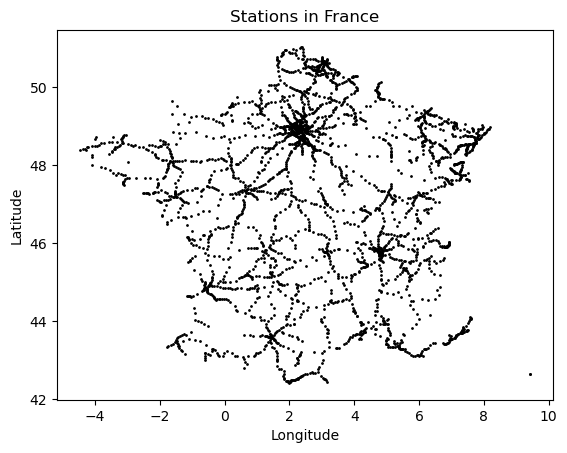

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(merged['lon'], merged['lat'], s=1, color='black')  
plt.title("Stations in France")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

/tmp/ipykernel_5157/3674027968.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(lon, lat, c=colors, s=1, cmap=cmap)


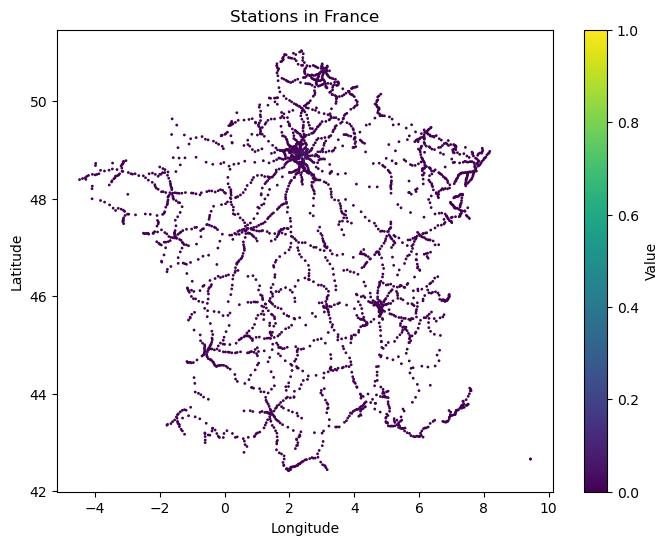

In [67]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# Example continuous data, replace with your actual continuous variable
continuous_variable = merged['total_voyageurs_2023']/10000  # Replace 'value' with your column name
lon = merged['lon']
lat = merged['lat']

# Normalize the data for coloring
norm = mcolors.Normalize(vmin=continuous_variable.min(), vmax=continuous_variable.max())
cmap = cm.viridis  # Choose a colormap
colors = cmap(norm(continuous_variable))

# Create the scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(lon, lat, c=colors, s=1, cmap=cmap)
plt.title("Stations in France")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Add a colorbar as the legend
cbar = plt.colorbar(scatter, ax=plt.gca())
cbar.set_label("Value")  # Replace "Value" with your continuous variable's name

plt.show()


In [2]:
print(len(merged['total_voyageurs_2023']), len(merged['lon']), len(merged['lat']))


NameError: name 'merged' is not defined

In [ ]:
import folium
import requests


geojson_url = "https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements-version-simplifiee.geojson"
geojson_data = requests.get(geojson_url).json()
#Create a base map centered on France
france_map = folium.Map(location=[46.603354, 1.888334], zoom_start=6)
#SON layer to the map with style
folium.GeoJson(
    geojson_data,
    name="Departments",
    style_function=lambda x: {
        'fillColor': '#ff7800',  # Use distinct colors or randomization for better visibility
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.5
    },
    tooltip=folium.GeoJsonTooltip(fields=["nom"], aliases=["Department"])  # Tooltip to show department name
).add_to(france_map)
folium.LayerControl().add_to(france_map)




In [63]:
france_map

In [15]:

merged=get_absent_lat_lon_from_gouv_api(merged)
merged.isna().sum()

90 absent addresses filled successfully


total_voyageurs_2023       0
code_postal                0
nom_gare                   0
uic                        0
codeinsee                 90
lon                        0
lat                        0
taux_de_conformite      1474
service_wifi              49
dtype: int64